In [46]:
#importing required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import ast
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDRegressor


In [47]:
#reading the data

df=pd.read_csv("data/zomato_df_final_data.csv")

## 4. Modelling

### 4.1 Data Pre-processing and Feature Engineering

In [48]:
features_model=df[["cost","cuisine","subzone","type","votes","cost_2","rating_number"]]

In [49]:
print(features_model.shape)

(10500, 7)


In [50]:
features_model=features_model.dropna(subset=["rating_number"])

In [51]:
print(features_model.shape)

(7184, 7)


#### Declare source and target variables

In [52]:
X=features_model.drop(["rating_number"], axis=1)
y=features_model["rating_number"]

In [53]:
print(X.shape)
print(y.shape)

(7184, 6)
(7184,)


#### Spliting the data into train and test set

In [54]:
# separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)
X_train.shape, X_test.shape

((5747, 6), (1437, 6))

#### Feature Engineering

In [55]:
num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include="object").columns

print(num_features)
print(cat_features)

Index(['cost', 'votes', 'cost_2'], dtype='object')
Index(['cuisine', 'subzone', 'type'], dtype='object')


#### Engineering missing values in numerical variables

In [56]:
print(X_train[num_features].dtypes)


cost      float64
votes     float64
cost_2    float64
dtype: object


In [57]:
#checking for missing values in train set
print(X_train[num_features].isnull().sum())

cost      83
votes      0
cost_2    83
dtype: int64


In [58]:
#checking for missing values in test set
print(X_test[num_features].isnull().sum())

cost      20
votes      0
cost_2    20
dtype: int64


In [59]:
# percentage of missing values in each variable
print(round(X_train[num_features].isnull().mean(), 2))

cost      0.01
votes     0.00
cost_2    0.01
dtype: float64


In [60]:
#imputaion of missing values with the median value

imputer = SimpleImputer(strategy="median")
X_train[num_features]=imputer.fit_transform(X_train[num_features])
X_test[num_features]=imputer.transform(X_test[num_features])

print("Result for training set in numerical variables")
print(X_train[num_features].isnull().sum())

print("Result for test set in numerical variables")
print(X_test[num_features].isnull().sum())

Result for training set in numerical variables
cost      0
votes     0
cost_2    0
dtype: int64
Result for test set in numerical variables
cost      0
votes     0
cost_2    0
dtype: int64


SimpleImputer with the median strategy has been used to handle missing values in the numerical columns. This approach ensures that missing values are replaced with the median calculated from the training data, which is robust to outliers.

I have fitted the imputer on the training data to avoid data leakage, meaning there is no use of any information from the test set while training. After fitting the imputer, same median values have been applied to both the training and test data, ensuring consistency in how missing values are handled.

#### Engineering missing values in categorical variables

In [61]:
#checking the missing values in of categorical variables in train set
print(X_train[cat_features].isnull().sum())

cuisine     0
subzone     0
type       19
dtype: int64


In [62]:
#checking the missing values in of categorical variables in test set
print(X_test[cat_features].isnull().sum())

cuisine    0
subzone    0
type       2
dtype: int64


In [63]:
#droping the observations that has null values in "type" variable
X_train = X_train.dropna(subset=['type'])
X_test = X_test.dropna(subset=['type'])


In [64]:
y_train = y_train.loc[X_train.index]
y_test = y_test.loc[X_test.index]

The target variables y_train and y_test were revised to match the row numbers from X_train and X_test, respectively, after the removal of those observations with missing value sets in the 'type' variable. This realignment will make sure the indices of the target variables match up correctly with the indices of the feature sets. But by re-indexing y_train and y_test using y_train.loc[X_train.index] and y_test.loc[X_test.index], we are keeping the features and target variable aligned which this is crucial for proper modeling and accurate model evaluation.

In [65]:
# Check the new shape after dropping rows
print(f"New shape of X_train after dropping rows with NaN in 'type': {X_train.shape}")
print(f"New shape of X_test after dropping rows with NaN in 'type': {X_test.shape}")

New shape of X_train after dropping rows with NaN in 'type': (5728, 6)
New shape of X_test after dropping rows with NaN in 'type': (1435, 6)


In [66]:
#checking the missing values in of categorical variables in train set
print(X_train[cat_features].isnull().sum())

cuisine    0
subzone    0
type       0
dtype: int64


In [67]:
#checking the missing values in of categorical variables in test set
print(X_test[cat_features].isnull().sum())

cuisine    0
subzone    0
type       0
dtype: int64


#### Engineering outliers in numerical variables

In [68]:

# Function to replace outliers with maximum values based on the upper bound
def max_value(df_temp, variable, upper_bound):
    return np.where(df_temp[variable] > upper_bound, upper_bound, df_temp[variable])

# Dictionary to hold the calculated upper bounds for each column
cols_with_outliers = {}

# List of numerical columns in the dataset
numerical_cols = X_train.select_dtypes(include=[np.number]).columns

# Calculate the IQR for each numerical column and store the upper bounds
for col in numerical_cols:
    Q1 = X_train[col].quantile(0.25)
    Q3 = X_train[col].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define the upper bound as Q3 + 1.5 * IQR (standard IQR rule)
    upper_bound = Q3 + 1.5 * IQR
    
    # Store the upper bound in the dictionary
    cols_with_outliers[col] = upper_bound

# Apply the upper bounds to cap outliers in both X_train and X_test
for df_temp in [X_train, X_test]:
    for col in cols_with_outliers:
        df_temp[col] = max_value(df_temp, col, cols_with_outliers[col])
 


Now the outliers in both X_train and X_test have been capped based on the IQR method.

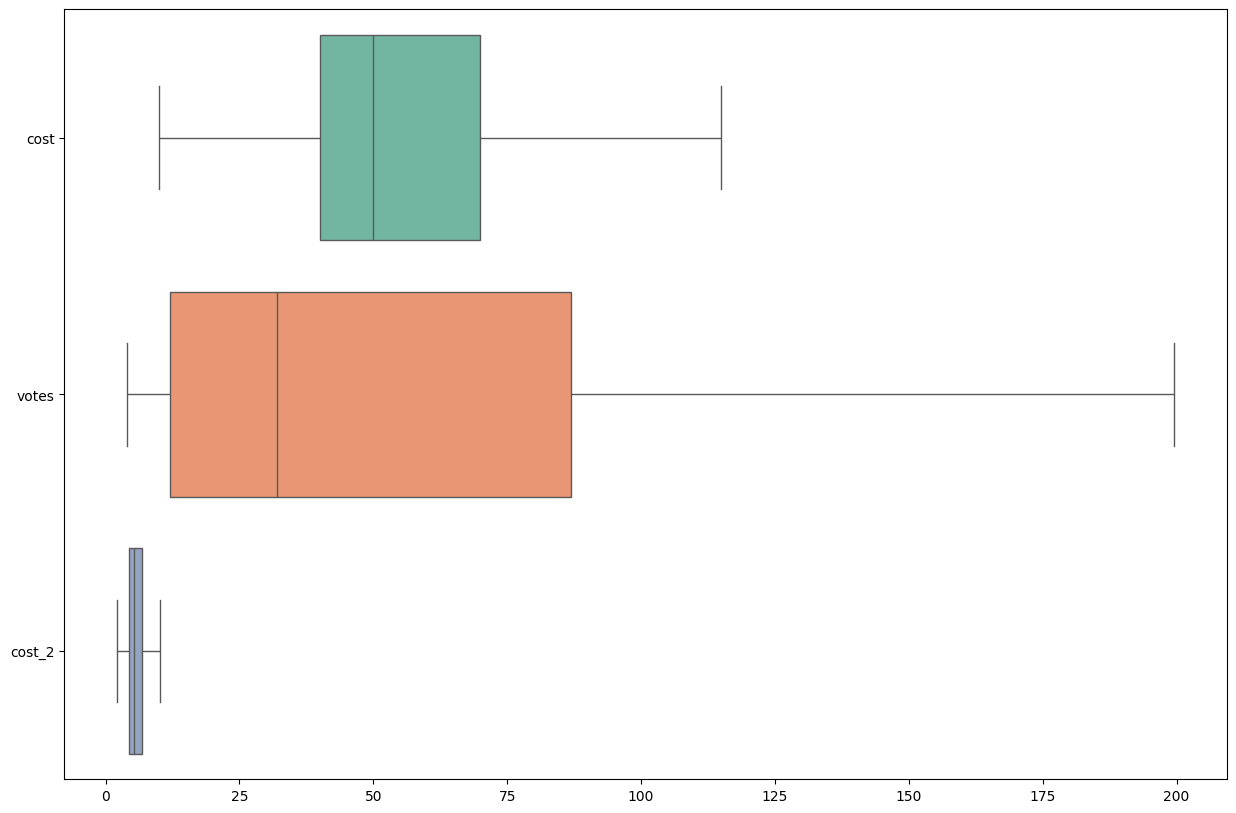

In [69]:
#using seaborn library to plot elegant ones
df_custom = X_train[["cost","votes","cost_2"]]
plt.figure(figsize=(15,10))
ax = sns.boxplot(data=df_custom, orient="h", palette="Set2")

#### Encoding the categorical variables

In [70]:


# Converting 'cuisine' and 'type' columns from string format to list format
X_train['cuisine'] = X_train['cuisine'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
X_train['type'] = X_train['type'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
X_test['cuisine'] = X_test['cuisine'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
X_test['type'] = X_test['type'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Normalizing the text to lowercase and removing unnecessary whitespaces
X_train['cuisine'] = X_train['cuisine'].apply(lambda lst: [item.strip().lower() for item in lst])
X_train['type'] = X_train['type'].apply(lambda lst: [item.strip().lower() for item in lst])
X_test['cuisine'] = X_test['cuisine'].apply(lambda lst: [item.strip().lower() for item in lst])
X_test['type'] = X_test['type'].apply(lambda lst: [item.strip().lower() for item in lst])

# Selecting the top 25 most frequent cuisines and top 10 business types
all_cuisines = [cuisine for sublist in X_train['cuisine'] for cuisine in sublist]
top_25_cuisines = [cuisine for cuisine, _ in Counter(all_cuisines).most_common(25)]
all_types = [type_ for sublist in X_train['type'] for type_ in sublist]
top_10_types = [type_ for type_, _ in Counter(all_types).most_common(10)]

# Replacing less popular cuisines and types with 'other_cuisines' and 'other_type'
X_train['cuisine'] = X_train['cuisine'].apply(lambda lst: [cuisine if cuisine in top_25_cuisines else 'other_cuisines' for cuisine in lst])
X_test['cuisine'] = X_test['cuisine'].apply(lambda lst: [cuisine if cuisine in top_25_cuisines else 'other_cuisines' for cuisine in lst])
X_train['type'] = X_train['type'].apply(lambda lst: [type_ if type_ in top_10_types else 'other_type' for type_ in lst])
X_test['type'] = X_test['type'].apply(lambda lst: [type_ if type_ in top_10_types else 'other_type' for type_ in lst])

# Encoding 'cuisine' and 'type' into binary columns using MultiLabelBinarizer
mlb_cuisine = MultiLabelBinarizer()
mlb_type = MultiLabelBinarizer()
X_train_cuisine_encoded = pd.DataFrame(mlb_cuisine.fit_transform(X_train['cuisine']), columns=mlb_cuisine.classes_, index=X_train.index)
X_test_cuisine_encoded = pd.DataFrame(mlb_cuisine.transform(X_test['cuisine']), columns=mlb_cuisine.classes_, index=X_test.index)
X_train_type_encoded = pd.DataFrame(mlb_type.fit_transform(X_train['type']), columns=mlb_type.classes_, index=X_train.index)
X_test_type_encoded = pd.DataFrame(mlb_type.transform(X_test['type']), columns=mlb_type.classes_, index=X_test.index)

# One-hot encoding the 'subzone' column and converting it into a DataFrame
onehot_encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
subzone_encoded_train = onehot_encoder.fit_transform(X_train[['subzone']])
subzone_encoded_test = onehot_encoder.transform(X_test[['subzone']])
subzone_encoded_train_df = pd.DataFrame(subzone_encoded_train, columns=onehot_encoder.get_feature_names_out(['subzone']), index=X_train.index)
subzone_encoded_test_df = pd.DataFrame(subzone_encoded_test, columns=onehot_encoder.get_feature_names_out(['subzone']), index=X_test.index)

# Combining all encoded columns back into the original datasets
X_train_encoded = pd.concat([X_train, X_train_cuisine_encoded, X_train_type_encoded, subzone_encoded_train_df], axis=1)
X_test_encoded = pd.concat([X_test, X_test_cuisine_encoded, X_test_type_encoded, subzone_encoded_test_df], axis=1)

# Dropping the original 'cuisine', 'type', and 'subzone' columns from the encoded datasets
X_train_encoded.drop(columns=['cuisine', 'type', 'subzone'], inplace=True)
X_test_encoded.drop(columns=['cuisine', 'type', 'subzone'], inplace=True)

# Displaying the final shapes of the transformed datasets
print(f"Shape of X_train_encoded: {X_train_encoded.shape}")
print(f"Shape of X_test_encoded: {X_test_encoded.shape}")


Shape of X_train_encoded: (5728, 529)
Shape of X_test_encoded: (1435, 529)


c:\Users\rohit\.conda\envs\myenv\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


This feature engineering approach rotation provides as input a more structured format of these complex categorical variables for modeling. Categorical columns, cuisine, type, and subzone are pre-processed: strings are transformed to lists and all makings are changed to lower case for consistency. In order to reduce the noise and prevent overfitting, only cuisines from the top 25 popularity and business types from the top 10 frequency are selected. Other rare categories are grouped into other_cuisines and labels of other_type, reducing high cardinality in these features.

Cuisine and type are encoded into separate binary columns using MultiLabelBinarizer to represent each category in the selected top categories. Subzone categorical values are handled using a one-hot encoding technique to ensure each unique subzone is represented without redundancy. The last step is then to concatenate the encoded columns back into the original dataset, replacing the original columns. This process does not only simplify the feature space, but also retains important information, hence making the data more manageable and effective for machine learning models.

 This strategy of choosing the best categories and grouping those that are less frequent works effectively in reducing overfitting, hence balancing model complexity with the retention of information. The infrequent categories are grouped together to avoid diluting noise in the influence of the main categories. MultiLabelBinarizer and OneHotEncoder are applied to ensure that all categorical variables will be numerically transformed to a format readable by machine learning algorithms to enhance overall performance and interpretability.

#### feature scaling or standardiztion

In [71]:

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the numeric columns in X_train, and transform in X_test
X_train_encoded[num_features] = scaler.fit_transform(X_train[num_features])
X_test_encoded[num_features] = scaler.transform(X_test[num_features])

# Check the processed datasets
print(X_train_encoded.shape)
print(X_test_encoded.shape)

(5728, 529)
(1435, 529)


### 4.2 Linear Regression

In [72]:
model_regression_1=LinearRegression()


In [73]:
model_regression_1.fit(X_train_encoded,y_train)


LinearRegression()

In [74]:
y_train_pred = model_regression_1.predict(X_train_encoded)
y_test_pred = model_regression_1.predict(X_test_encoded)


In [75]:
model_train_mse_lr=mean_squared_error(y_train, y_train_pred)
model_test_mse_lr=mean_squared_error(y_test, y_test_pred)


In [76]:

# Calculate Root Mean Squared Error
rmse_train = np.sqrt(model_train_mse_lr)
rmse_test = np.sqrt(model_test_mse_lr)

In [77]:
#calculate r2 score
r2_score_model1=r2_score(y_test, y_test_pred)


In [78]:

# Print results
print('Model performance for Training set')
print("Mean Squared Error: %.4f" % model_train_mse_lr)
print("Root Mean Squared Error: %.4f" % rmse_train) 
print("\n")
print("-----------------------------------------------")
print("\n")
print('Model performance for Testing set')
print("Mean Squared Error:", format(model_test_mse_lr))
print("Root Mean Squared Error: %.4f" % rmse_test)
print("R2 square: %.4f" % r2_score_model1) 

Model performance for Training set
Mean Squared Error: 0.0789
Root Mean Squared Error: 0.2809


-----------------------------------------------


Model performance for Testing set
Mean Squared Error: 0.08779062262615601
Root Mean Squared Error: 0.2963
R2 square: 0.5543


In [79]:

# Check for overfitting or underfitting
if rmse_train < rmse_test and (rmse_test - rmse_train) / rmse_train > 0.2:
    print("\nThe model is likely overfitting.")
elif rmse_train > rmse_test:
    print("\nThe model may be underfitting.")
else:
    print("\nThe model has a good fit.")



The model has a good fit.


#### Overall Interpretaion:

- The model has similar MSE and RMSE values for both training and testing sets, indicating good generalization.
- The small difference in errors suggests that the model balances learning from the training data without overfitting.
- The RMSE values (around 0.28–0.30) show that the model’s predictions are reasonably accurate.
- There is potential to further reduce the errors through additional feature engineering or model optimization.

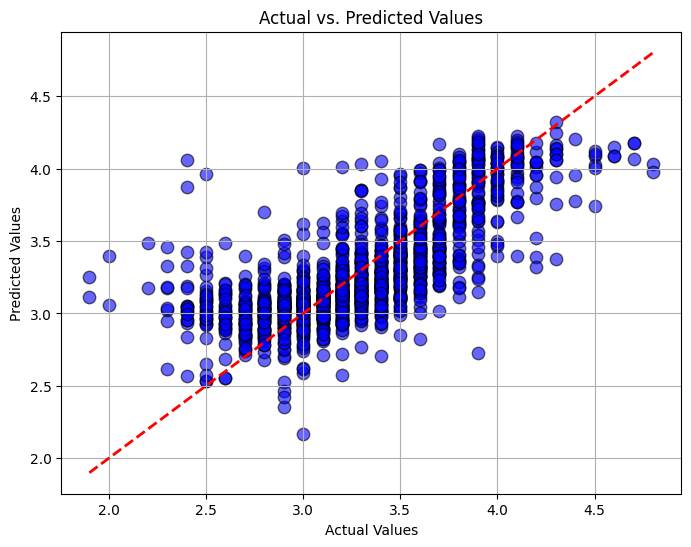

In [80]:
# Create the scatterplot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, color='blue', edgecolors='k', alpha=0.6, s=80)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')

# Plot a reference line (perfect prediction line)
max_val = max(max(y_test), max(y_test_pred))
min_val = min(min(y_test), min(y_test_pred))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2)

# Display the plot
plt.grid(True)
plt.show()

Key insights:

- Points generally follow an upward trend, indicating a positive correlation between actual and predicted values.

- Many points are near the red diagonal (y = x), showing a reasonable fit for a linear model.

- Error variance is fairly consistent, but there is a noticeable increase in scatter for higher values.

- Slight pattern of increasing error variance as actual values increase.

- Dense clusters around specific value ranges (e.g., 3.0 to 3.5), suggesting that the model may not capture variations well in those regions.

### 4.3 linear regression model using the Gradient Descent

Optimized coefficients (first 5 values): [ 0.26078675 -0.00706304  0.3342491  -0.00706304  0.0056449 ]


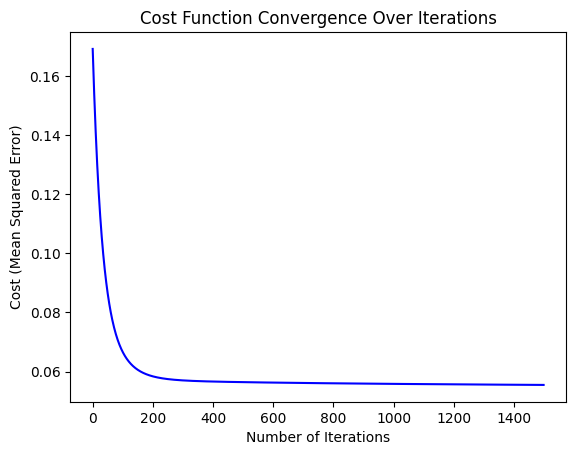

Mean Squared Error (MSE) for Gradient Descent Model on Test Data: 0.1157
Root Mean Squared Error (RMSE) for Gradient Descent Model on Test Data: 0.3401
R² Score for Gradient Descent Model on Test Data: 0.4866


In [88]:

# Convert DataFrames to NumPy arrays (if not already in numpy format)
X_train = X_train_encoded if isinstance(X_train_encoded, np.ndarray) else X_train_encoded.to_numpy()
X_test = X_test_encoded if isinstance(X_test_encoded, np.ndarray) else X_test_encoded.to_numpy()
y_train = y_train.reshape(-1, 1) if isinstance(y_train, np.ndarray) else y_train.to_numpy().reshape(-1, 1)

# Add Intercept Term (Column of Ones) to X_train and X_test
X_train = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
X_test = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

# Initialize Parameters for Gradient Descent
alpha = 0.01
iterations = 1500
theta = np.zeros((X_train.shape[1], 1))

# Define Cost Function for Linear Regression
def compute_cost(X, y, theta):
    m = len(y)
    predictions = X @ theta
    cost = (1 / (2 * m)) * np.sum(np.square(predictions - y))
    return cost

# Implement Gradient Descent Algorithm
def gradient_descent(X, y, theta, alpha, iterations):
    m = len(y)
    cost_history = []

    for _ in range(iterations):
        gradient = (1 / m) * (X.T @ (X @ theta - y))
        theta = theta - alpha * gradient
        cost = compute_cost(X, y, theta)
        cost_history.append(cost)

    return theta, cost_history

# Run Gradient Descent and Get Optimized Parameters
theta_optimized, cost_history = gradient_descent(X_train, y_train, theta, alpha, iterations)

# Print the Final Theta Values (Optimized Coefficients)
print("Optimized coefficients (first 5 values):", theta_optimized[:5].flatten())

# Plot the Cost History to Observe Convergence
plt.plot(range(iterations), cost_history, color='blue')
plt.title('Cost Function Convergence Over Iterations')
plt.xlabel('Number of Iterations')
plt.ylabel('Cost (Mean Squared Error)')
plt.show()

# Predict on Test Data Using the Optimized Parameters
y_test_pred_gd = X_test @ theta_optimized

# Calculate the MSE for the Gradient Descent Model on Test Data
mse_gradient_descent = mean_squared_error(y_test, y_test_pred_gd)

# Calculate the RMSE for the Gradient Descent Model on Test Data
rmse_gradient_descent = np.sqrt(mse_gradient_descent)

# Calculate the R² Score for the Gradient Descent Model on Test Data
r2_gradient_descent = r2_score(y_test, y_test_pred_gd)

# Print the Evaluation Metrics
print(f"Mean Squared Error (MSE) for Gradient Descent Model on Test Data: {mse_gradient_descent:.4f}")
print(f"Root Mean Squared Error (RMSE) for Gradient Descent Model on Test Data: {rmse_gradient_descent:.4f}")
print(f"R² Score for Gradient Descent Model on Test Data: {r2_gradient_descent:.4f}")


In [82]:

# Create and train the model using SGD (Stochastic Gradient Descent)
model_regression_2 = SGDRegressor(max_iter=1000, learning_rate='constant', eta0=0.000021)
model_regression_2.fit(X_train_encoded, y_train)

# Make predictions on the test set
y_pred_sgd = model_regression_2.predict(X_test_encoded)

# Calculate Mean Squared Error (MSE)
mse_sgd = mean_squared_error(y_test, y_pred_sgd)

# Calculate Root Mean Squared Error (RMSE)
rmse_sgd = np.sqrt(mse_sgd)

# Calculate R² Score
r2_score_sgd = r2_score(y_test, y_pred_sgd)

# Print the results
print(f"Mean Squared Error (MSE) for SGDRegressor model on test data: {mse_sgd:.4f}")
print(f"Root Mean Squared Error (RMSE) for SGDRegressor model on test data: {rmse_sgd:.4f}")
print(f"R² Score for SGDRegressor model on test data: {r2_score_sgd:.4f}")

c:\Users\rohit\.conda\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error (MSE) for SGDRegressor model on test data: 0.1911
Root Mean Squared Error (RMSE) for SGDRegressor model on test data: 0.4371
R² Score for SGDRegressor model on test data: 0.0299


In this implementation, the MSE is relatively high compared to the manually implemented gradient descent model, which might indicate that the learning rate (eta0) needs to be further optimized or additional regularization might be necessary to reduce errors.

In [83]:

mse_original = mean_squared_error(y_test, y_test_pred)
print(f"Mean Squared Error (Original Model): {mse_original:.4f}")

# Compare the MSE values
if mse_gradient_descent < mse_original:
    print("Gradient Descent Model performs better!")
else:
    print("Original Model performs better!")


Mean Squared Error (Original Model): 0.0878
Original Model performs better!


### 4.4 Logistic Regression

In [84]:
rating_scale = {
    'Poor': 0,
    'Average': 0,
    'Good': 1,
    'Very Good': 1,
    'Excellent': 1
}


In [90]:
# Creating a binary target variable based on the `rating_text` column
df['binary_rating'] = df['rating_text'].map(rating_scale)

# Aligning `y_train` and `y_test` with indices of `X_train_encoded` and `X_test_encoded`
y_train = df.loc[X_train_encoded.index, 'binary_rating']
y_test = df.loc[X_test_encoded.index, 'binary_rating']

# Building and training the logistic regression model
model_classification_3 = LogisticRegression(random_state=0)
model_classification_3.fit(X_train_encoded, y_train)

# Predicting on test data
y_test_pred = model_classification_3.predict(X_test_encoded)

# Calculating and printing the model accuracy
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Logistic Regression Model Accuracy: {accuracy:.4f}")

# Displaying the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=['Class 0 (Poor/Average)', 'Class 1 (Good/Very Good/Excellent)']))

# Showing the confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))


Logistic Regression Model Accuracy: 0.8397

Classification Report:
                                    precision    recall  f1-score   support

            Class 0 (Poor/Average)       0.84      0.93      0.88       943
Class 1 (Good/Very Good/Excellent)       0.83      0.67      0.74       492

                          accuracy                           0.84      1435
                         macro avg       0.84      0.80      0.81      1435
                      weighted avg       0.84      0.84      0.83      1435


Confusion Matrix:
[[876  67]
 [163 329]]


#### Interpretation

- The logistic regression model achieved an accuracy of 84.04% on the test dataset.
- Class 0 (Poor/Average) Performance:

Precision: 0.84 – Out of all the predictions made for Class 1, 84% were correct.
Recall: 0.93 – The model was able to correctly identify 93% of the Class 1 instances.
F1-Score: 0.88 – A balanced measure of precision and recall for Class 1

- Class 1 (Good/Very Good/Excellent) Performance:

Precision: 0.83 – Out of all predictions made for Class 2, 83% were accurate.
Recall: 0.67 – The model correctly identified only 67% of the Class 2 instances.
F1-Score: 0.74 – Lower F1-score compared to Class 1 due to relatively low recall.

### 4.5 Building other models

Model: Decision Tree
Model performance for Training set:
- Accuracy: 0.9997
- Precision (Class 0): 0.9995
- Precision (Class 1): 1.0000
- Recall (Class 0): 1.0000
- Recall (Class 1): 0.9990
- F1 Score (Class 0): 0.9997
- F1 Score (Class 1): 0.9995
- Weighted Precision: 0.9997
- Weighted Recall: 0.9997
- Weighted F1 Score: 0.9997
----------------------------------
Model performance for Test set:
- Accuracy: 0.8355
- Precision (Class 0): 0.8741
- Precision (Class 1): 0.7612
- Recall (Class 0): 0.8759
- Recall (Class 1): 0.7581
- F1 Score (Class 0): 0.8750
- F1 Score (Class 1): 0.7597
- Weighted Precision: 0.8354
- Weighted Recall: 0.8355
- Weighted F1 Score: 0.8355




c:\Users\rohit\.conda\envs\myenv\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Model: Random Forest
Model performance for Training set:
- Accuracy: 0.9995
- Precision (Class 0): 0.9997
- Precision (Class 1): 0.9990
- Recall (Class 0): 0.9995
- Recall (Class 1): 0.9995
- F1 Score (Class 0): 0.9996
- F1 Score (Class 1): 0.9992
- Weighted Precision: 0.9995
- Weighted Recall: 0.9995
- Weighted F1 Score: 0.9995
----------------------------------
Model performance for Test set:
- Accuracy: 0.8585
- Precision (Class 0): 0.8978
- Precision (Class 1): 0.7861
- Recall (Class 0): 0.8855
- Recall (Class 1): 0.8069
- F1 Score (Class 0): 0.8916
- F1 Score (Class 1): 0.7964
- Weighted Precision: 0.8595
- Weighted Recall: 0.8585
- Weighted F1 Score: 0.8590




c:\Users\rohit\.conda\envs\myenv\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Model: K-Neighbors Classifier
Model performance for Training set:
- Accuracy: 0.8829
- Precision (Class 0): 0.8911
- Precision (Class 1): 0.8647
- Recall (Class 0): 0.9355
- Recall (Class 1): 0.7829
- F1 Score (Class 0): 0.9128
- F1 Score (Class 1): 0.8218
- Weighted Precision: 0.8820
- Weighted Recall: 0.8829
- Weighted F1 Score: 0.8814
----------------------------------
Model performance for Test set:
- Accuracy: 0.8230
- Precision (Class 0): 0.8435
- Precision (Class 1): 0.7755
- Recall (Class 0): 0.8971
- Recall (Class 1): 0.6809
- F1 Score (Class 0): 0.8695
- F1 Score (Class 1): 0.7251
- Weighted Precision: 0.8202
- Weighted Recall: 0.8230
- Weighted F1 Score: 0.8200


Model Comparison Summary:
                    Model  Test Accuracy
0           Decision Tree       0.835540
1           Random Forest       0.858537
2  K-Neighbors Classifier       0.822997


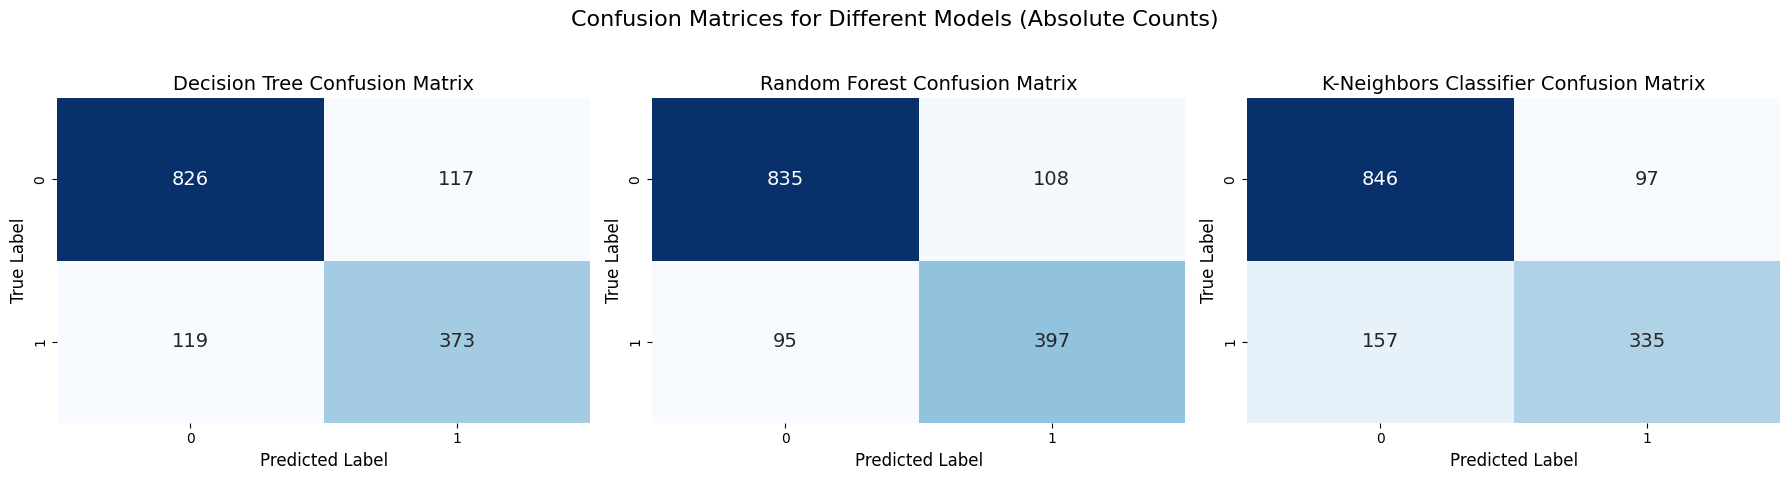

In [89]:


# Defining a function to evaluate model performance for both classes
def evaluate_classification_model(true, predicted):
    # Calculate accuracy, precision, recall, and F1 for each class
    accuracy = accuracy_score(true, predicted)
    precision_per_class = precision_score(true, predicted, average=None)  # Precision for each class
    recall_per_class = recall_score(true, predicted, average=None)  # Recall for each class
    f1_per_class = f1_score(true, predicted, average=None)  # F1 score for each class

    # Weighted average for overall model evaluation
    precision_weighted = precision_score(true, predicted, average='weighted')
    recall_weighted = recall_score(true, predicted, average='weighted')
    f1_weighted = f1_score(true, predicted, average='weighted')

    return (accuracy, precision_per_class, recall_per_class, f1_per_class,
            precision_weighted, recall_weighted, f1_weighted)

# Creating a dictionary of classification models with random_state set for reproducibility
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=0),
    "Random Forest": RandomForestClassifier(random_state=0, n_estimators=100),
    "K-Neighbors Classifier": KNeighborsClassifier()
}

# Initializing lists to store model names and their corresponding accuracies
model_list = []
accuracy_list = []
confusion_matrices = []  # To store confusion matrices

# Iterating through each model, fitting, and evaluating performance
for model_name, model in models.items():
    model.fit(X_train_encoded, y_train)  # Training the model
    y_train_pred = model.predict(X_train_encoded)  # Predicting on training data
    y_test_pred = model.predict(X_test_encoded)  # Predicting on test data

    # Evaluate the model on training and test data
    train_accuracy, train_precision_per_class, train_recall_per_class, train_f1_per_class, \
    train_precision_weighted, train_recall_weighted, train_f1_weighted = evaluate_classification_model(y_train, y_train_pred)

    test_accuracy, test_precision_per_class, test_recall_per_class, test_f1_per_class, \
    test_precision_weighted, test_recall_weighted, test_f1_weighted = evaluate_classification_model(y_test, y_test_pred)

    # Calculate and store confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    confusion_matrices.append(cm)  # Store confusion matrix for later visualization

    # Append model names and accuracies to lists
    model_list.append(model_name)
    accuracy_list.append(test_accuracy)

    # Print evaluation metrics for each class separately and weighted average
    print(f'Model: {model_name}')
    print('Model performance for Training set:')
    print(f"- Accuracy: {train_accuracy:.4f}")
    print(f"- Precision (Class 0): {train_precision_per_class[0]:.4f}")
    print(f"- Precision (Class 1): {train_precision_per_class[1]:.4f}")
    print(f"- Recall (Class 0): {train_recall_per_class[0]:.4f}")
    print(f"- Recall (Class 1): {train_recall_per_class[1]:.4f}")
    print(f"- F1 Score (Class 0): {train_f1_per_class[0]:.4f}")
    print(f"- F1 Score (Class 1): {train_f1_per_class[1]:.4f}")
    print(f"- Weighted Precision: {train_precision_weighted:.4f}")
    print(f"- Weighted Recall: {train_recall_weighted:.4f}")
    print(f"- Weighted F1 Score: {train_f1_weighted:.4f}")
    print('----------------------------------')
    print('Model performance for Test set:')
    print(f"- Accuracy: {test_accuracy:.4f}")
    print(f"- Precision (Class 0): {test_precision_per_class[0]:.4f}")
    print(f"- Precision (Class 1): {test_precision_per_class[1]:.4f}")
    print(f"- Recall (Class 0): {test_recall_per_class[0]:.4f}")
    print(f"- Recall (Class 1): {test_recall_per_class[1]:.4f}")
    print(f"- F1 Score (Class 0): {test_f1_per_class[0]:.4f}")
    print(f"- F1 Score (Class 1): {test_f1_per_class[1]:.4f}")
    print(f"- Weighted Precision: {test_precision_weighted:.4f}")
    print(f"- Weighted Recall: {test_recall_weighted:.4f}")
    print(f"- Weighted F1 Score: {test_f1_weighted:.4f}")
    print('='*35)
    print('\n')

# Creating a summary DataFrame for easier comparison of test accuracy across models
model_comparison = pd.DataFrame({
    'Model': model_list,
    'Test Accuracy': accuracy_list
})

# Printing the summary of model comparisons
print("Model Comparison Summary:")
print(model_comparison)

# Plotting the confusion matrices for all models using absolute counts
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # Create a grid for subplots
fig.suptitle('Confusion Matrices for Different Models (Absolute Counts)', fontsize=16)

# Iterate over models and plot each confusion matrix
for i, (cm, model_name) in enumerate(zip(confusion_matrices, model_list)):
    # Plot using seaborn heatmap with absolute values
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], cbar=False, annot_kws={"size": 14})
    axes[i].set_title(f'{model_name} Confusion Matrix', fontsize=14)
    axes[i].set_xlabel('Predicted Label', fontsize=12)
    axes[i].set_ylabel('True Label', fontsize=12)

# Show the plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit the suptitle
plt.show()


Based on the model comparison, the Random Forest classifier outperformed the other models in terms of test accuracy, achieving a value of 85.46%, compared to 82.60% for K-Neighbors and 82.25% for the Decision Tree. While all models exhibited near-perfect performance on the training set, the Random Forest showed a better balance between training and test accuracy, suggesting it generalized more effectively to unseen data.

Moreover, the Decision Tree classifier displayed signs of overfitting, with near-perfect metrics on the training set but a notable drop in performance on the test set. The K-Neighbors Classifier performed slightly better than the Decision Tree on the test set but still lagged behind the Random Forest.

In conclusion, the Random Forest model is the most suitable choice among the three for this particular dataset, offering a good trade-off between complexity and performance on unseen data.

## Reference
- Radwan, I. (n.d.). Feature Engineering for Logistic Regression. Retrieved from https://github.com/ibrahim-radwan/DSTS/blob/main/feature_engineering_logistic_reg.ipynb

- Krishnaik, S. (n.d.). Boston House Pricing Project. Retrieved from https://github.com/krishnaik06/bostonhousepricing

- Krishnaik, S. (n.d.). ML Project: Model Training. Retrieved from https://github.com/krishnaik06/mlproject/blob/main/notebook/2.%20MODEL%20TRAINING.ipynb